In [ ]:
import numpy
import matplotlib.pyplot as plot
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import boston_housing

Берём входные данные из tensorflow.keras.datasets.boston_housing и нормализуем входные данные:
- Считаем среднее арифметическое по столбцам (mean)
- Выполняем поэлементное вычитание среднего арифметического в каждом столбце
- Считаем стандартное отклонение (std)
- Выполняем поэлементное деление в каждом столбце на отклонение

In [ ]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

Определяем функцию-фабрику для создания и компиляции сети:

In [ ]:
def build_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

Вспомогательные функции:
- lists_mean - принимает матрицу и возвращает поэлементную сумму строк матрицы поделенную на их число (среднее значение), будет использоваться для подсчета среднего mse и mae после k-fold cross-validation
- all_stat_append - используется для записи средних значений mse и mae в словарb all_mean_mae и all_mean_mse, где ключ - индекс модели

In [58]:
# Функция для поэлементного сложения списков сложенных в матрицу
def lists_mean(matrix):
    # Проверяем чтобы размеры строк были равны между собой и != 0
    n = len(matrix[0])
    for row in matrix:
        if len(row) != n or len(row) == 0:
            print('wrong input: ', n, '!=', len(row))
            return []
    # суммируем
    result = matrix[0]
    for row_id in range(1, len(matrix)):
        for id in range(0, len(result)):
            result[id] += matrix[row_id][id]
    
    # делим на число строк (считаем среднее)
    row_count = len(matrix)
    for idx in result:
        idx /= row_count

    return result

all_mean_mae = {}
all_mean_mse = {}

# Подсчёт среднего и добавление в словарь
def all_stat_append(history_matrix, index):
    all_mae = []
    all_mse = []
    
    for hist in history_matrix:
        all_mae.append(hist.history['mae'])
        all_mse.append(hist.history['loss'])

    all_mean_mae[index] = lists_mean(all_mae)
    all_mean_mse[index] = lists_mean(all_mse)


Функции для постройки графиков:
- init_plot и finalize_plot - используются для инициализации и отображения графиков
- append_to_plot - принимает список из k историй и строит на основании этих данных графики

In [ ]:
def build_plot(history_matrix):
    plot.rcParams["figure.figsize"] = (12, 12)
    figure, plot_arr = plot.subplots(2, 2)
    plot_arr[0, 0].set_title('mae')
    plot_arr[0, 1].set_title('mse')
    plot_arr[1, 0].set_title('mean mae')
    plot_arr[1, 1].set_title('mean mse')
    
    all_mae = []
    all_mse = []
    
    index = 1
    for hist in history_matrix:
        plot_arr[0, 0].plot(hist.history['mae'], label='fold' + str(index))
        plot_arr[0, 1].plot(hist.history['loss'], label='fold' + str(index))
        all_mae.append(hist.history['mae'])
        all_mse.append(hist.history['loss'])
        index += 1
        
    plot_arr[1, 0].plot(lists_mean(all_mae), label='mean mae')
    plot_arr[1, 1].plot(lists_mean(all_mse), label='mean mse')

    for x in [0, 1]:
        for y in [0 ,1]:
            plot_arr[x, y].legend()
    plot.show()
    plot.clf()

Определим функцию для обучения сети с перекрестной проверкой по K блокам. Сеть обучается с k разными наборами данных и num_epochs числом эпох, и возвращает список историй

In [ ]:
def fit_k_times(k, num_epochs):
    val_mse_arr = []
    val_mae_arr = []

    num_val_samples = len(train_data) // k
    history_matrix = []
    for i in range(k):
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
        
        partial_train_data = numpy.concatenate([train_data[:i * num_val_samples], 
            train_data[(i + 1) * num_val_samples:]], axis=0)

        partial_train_targets = numpy.concatenate(
            [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
        
        with tf.device("/CPU:0"):
            model = build_model()
            history = model.fit(partial_train_data, partial_train_targets,
                epochs=num_epochs, batch_size=1, verbose=0)
            val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
        
        val_mae_arr.append(val_mae)
        val_mse_arr.append(val_mse)

        print('fold#', i, 'val_mae=', val_mae, 'val_mse=', val_mse)

        history_matrix.append(history)

    m_val_mae = numpy.mean(val_mae_arr)
    m_val_mse = numpy.mean(val_mse_arr)
    print('mean val_mae=', m_val_mae, 'mean val_mse=', m_val_mse)

    return [history_matrix, m_val_mae, m_val_mse]

Исходная модель (k = 4, число эпох равно 100):

Пояснение к графикам:

1) k графиков mae во время применения перекрестной проверки
2) k графиков mse во время применения перекрестной проверки
3) Среднее величин графика 1
4) Среднее величин графика 2

fold# 0 val_mae= 2.2237536907196045 val_mse= 8.558058738708496
fold# 1 val_mae= 2.616278886795044 val_mse= 12.771166801452637
fold# 2 val_mae= 2.9998080730438232 val_mse= 18.767513275146484
fold# 3 val_mae= 2.27561616897583 val_mse= 10.153685569763184
mean val_mae= 2.5288642048835754 mean val_mse= 12.5626060962677


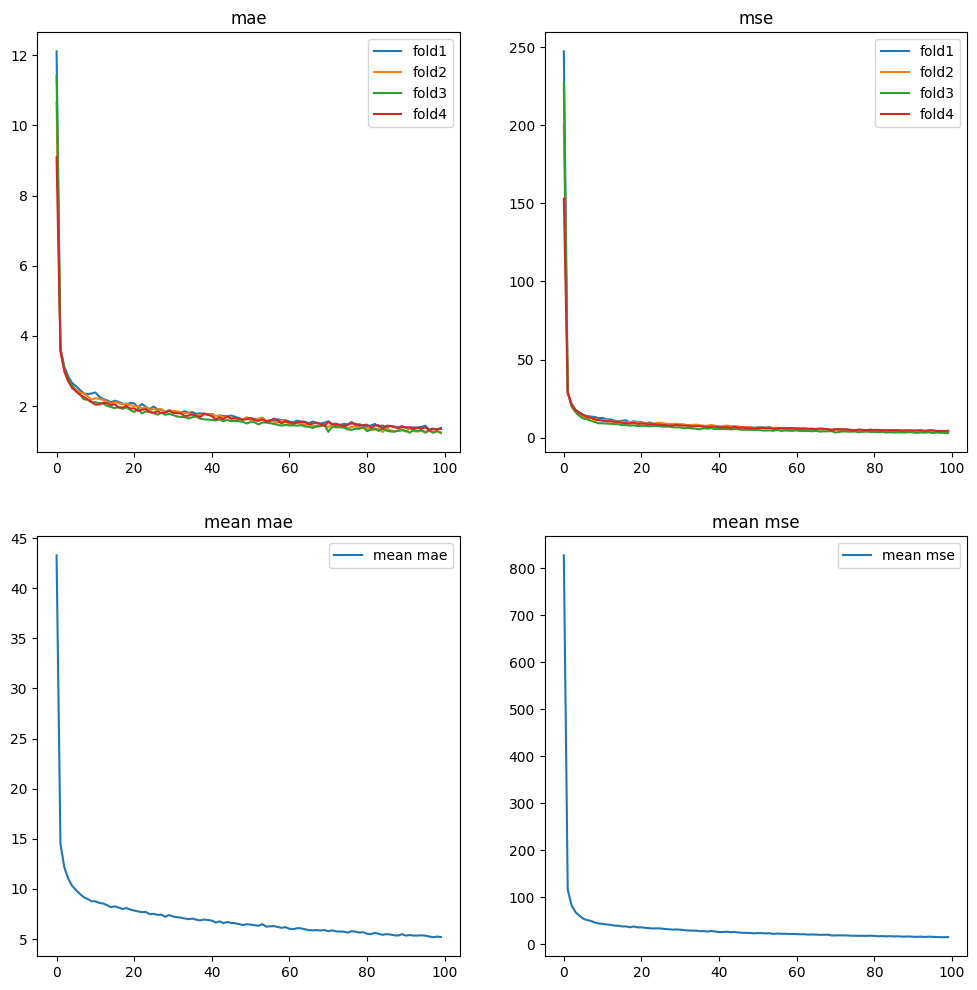

<Figure size 1200x1200 with 0 Axes>

In [13]:
k = 4
num_ep = 100
[model_1_history_matrix, mean_val_mae, mean_val_mse] = fit_k_times(k, num_ep)
all_scores = [[k, num_ep, mean_val_mae, mean_val_mse]]

build_plot(model_1_history_matrix)
all_stat_append(model_1_history_matrix, 1)

Во второй модели уменьшим число эпох в два раза:

Можно заметить, что в результате среднеквадратичная ошибка и средняя абсолютная ошибка оказались меньше чем в изначальной модели

fold# 0 val_mae= 2.2233028411865234 val_mse= 8.013193130493164
fold# 1 val_mae= 2.523557662963867 val_mse= 10.044136047363281
fold# 2 val_mae= 2.5986828804016113 val_mse= 14.016109466552734
fold# 3 val_mae= 2.405029535293579 val_mse= 11.855443000793457
mean val_mae= 2.4376432299613953 mean val_mse= 10.98222041130066


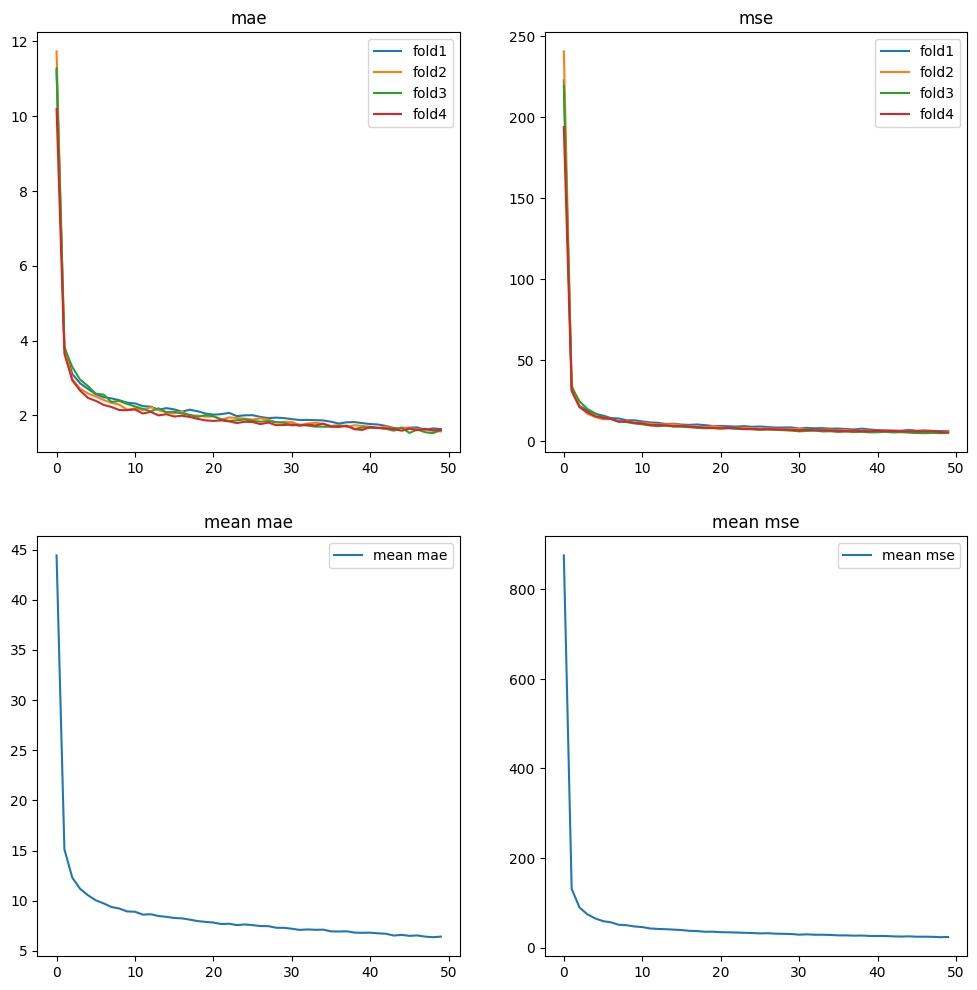

<Figure size 1200x1200 with 0 Axes>

In [14]:
k = 4
num_ep = 50
[model_2_history_matrix, mean_val_mae, mean_val_mse] = fit_k_times(k, num_ep)
all_scores = [[k, num_ep, mean_val_mae, mean_val_mse]]

build_plot(model_2_history_matrix)
all_stat_append(model_2_history_matrix, 2)

В третьей модели увеличим число эпох в 2 раза относительно исходной модели:

fold# 0 val_mae= 2.4637272357940674 val_mse= 10.602018356323242
fold# 1 val_mae= 3.400190830230713 val_mse= 26.81764793395996
fold# 2 val_mae= 3.049081325531006 val_mse= 20.874982833862305
fold# 3 val_mae= 2.4873011112213135 val_mse= 12.637036323547363
mean val_mae= 2.850075125694275 mean val_mse= 17.732921361923218


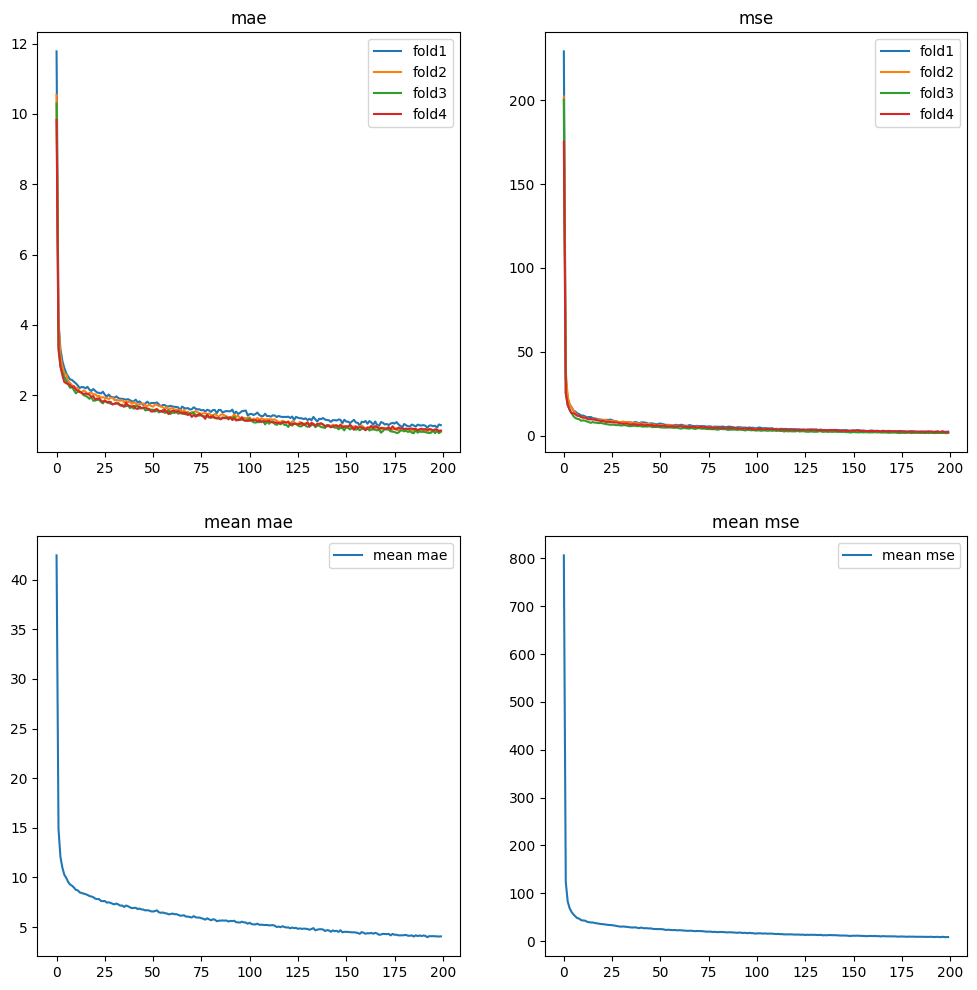

<Figure size 1200x1200 with 0 Axes>

In [20]:
k = 4
num_ep = 200
[model_3_history_matrix, mean_val_mae, mean_val_mse] = fit_k_times(k, num_ep)
all_scores = [[k, num_ep, mean_val_mae, mean_val_mse]]

build_plot(model_3_history_matrix)
all_stat_append(model_3_history_matrix, 3)

В четвёртой модели уменьшим k с 4 до 2:

Можно заметить, что в результате среднеквадратичная ошибка и средняя абсолютная ошибка оказались больше чем при обучении сети с изначальными параметрами

fold# 0 val_mae= 2.6129343509674072 val_mse= 13.8191556930542
fold# 1 val_mae= 2.6465814113616943 val_mse= 15.797332763671875
mean val_mae= 2.629757881164551 mean val_mse= 14.808244228363037


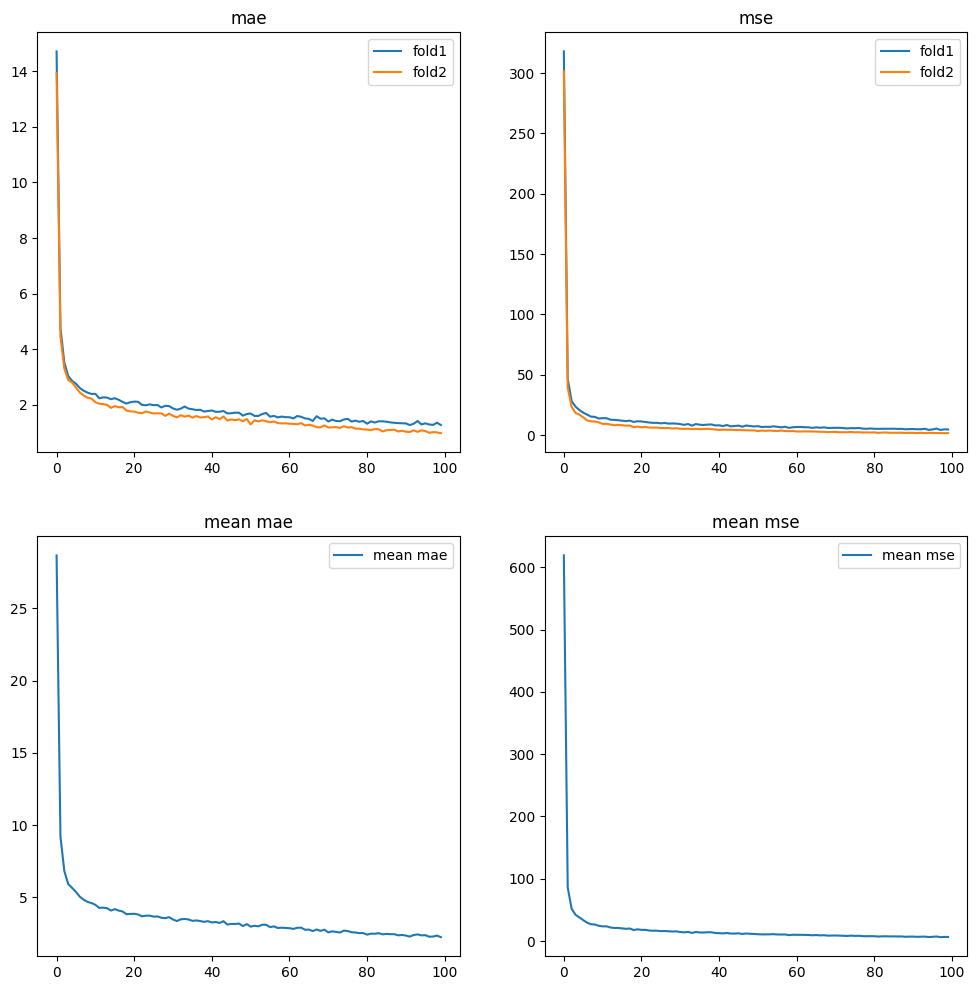

<Figure size 1200x1200 with 0 Axes>

In [16]:
k = 2
num_ep = 100
[model_4_history_matrix, mean_val_mae, mean_val_mse] = fit_k_times(k, num_ep)
all_scores = [[k, num_ep, mean_val_mae, mean_val_mse]]

build_plot(model_4_history_matrix)
all_stat_append(model_4_history_matrix, 4)

В пятой модели увеличим k с 4 до 6:

Можно заметить, что в результате среднеквадратичная ошибка и средняя абсолютная ошибка оказались меньше чем в изначальной модели

fold# 0 val_mae= 1.7331886291503906 val_mse= 7.737839221954346
fold# 1 val_mae= 2.3024990558624268 val_mse= 10.864763259887695
fold# 2 val_mae= 2.1072659492492676 val_mse= 8.071812629699707
fold# 3 val_mae= 2.415818452835083 val_mse= 10.517278671264648
fold# 4 val_mae= 2.743494749069214 val_mse= 21.18958282470703
fold# 5 val_mae= 1.7738080024719238 val_mse= 5.3594560623168945
mean val_mae= 2.1793458064397178 mean val_mse= 10.62345544497172


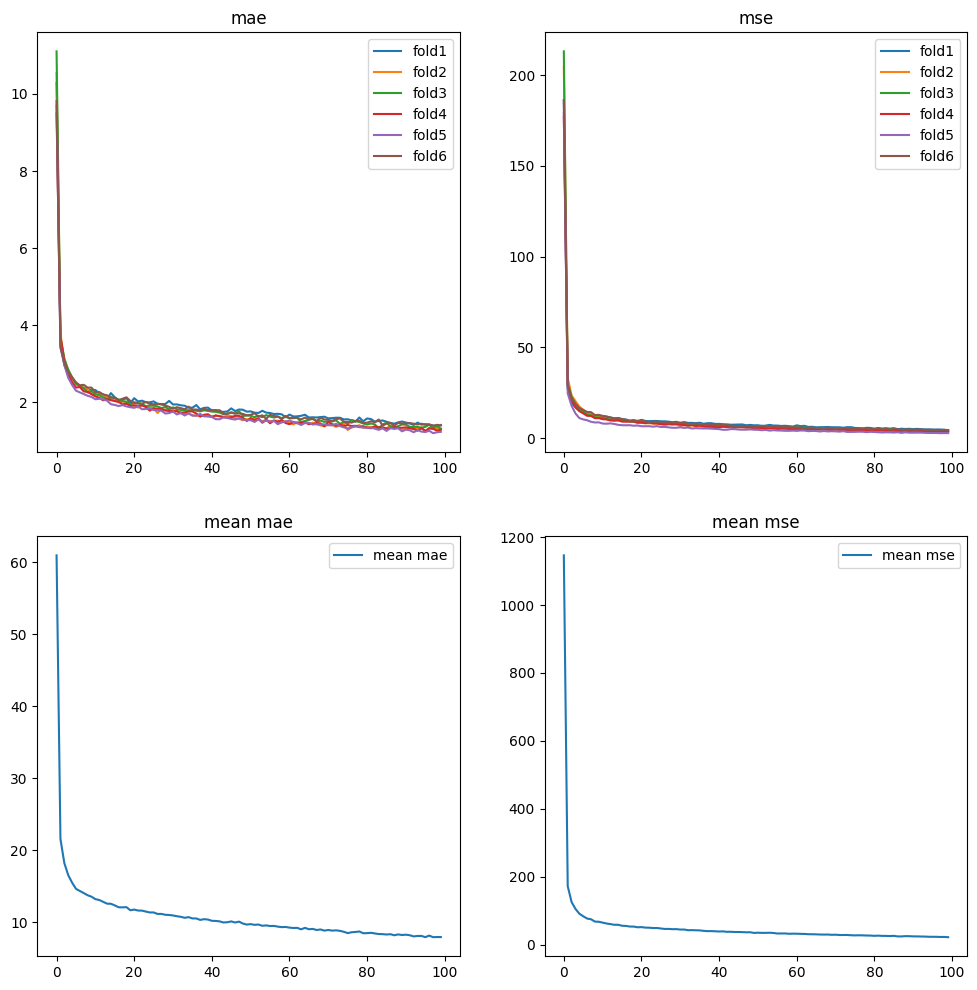

<Figure size 1200x1200 with 0 Axes>

In [17]:
k = 6
num_ep = 100
[model_5_history_matrix, mean_val_mae, mean_val_mse] = fit_k_times(k, num_ep)
all_scores = [[k, num_ep, mean_val_mae, mean_val_mse]]

build_plot(model_5_history_matrix)
all_stat_append(model_5_history_matrix, 5)

Отобразим графики усреднённых величин mae и mse по всем моделям:

<Figure size 1200x1200 with 0 Axes>

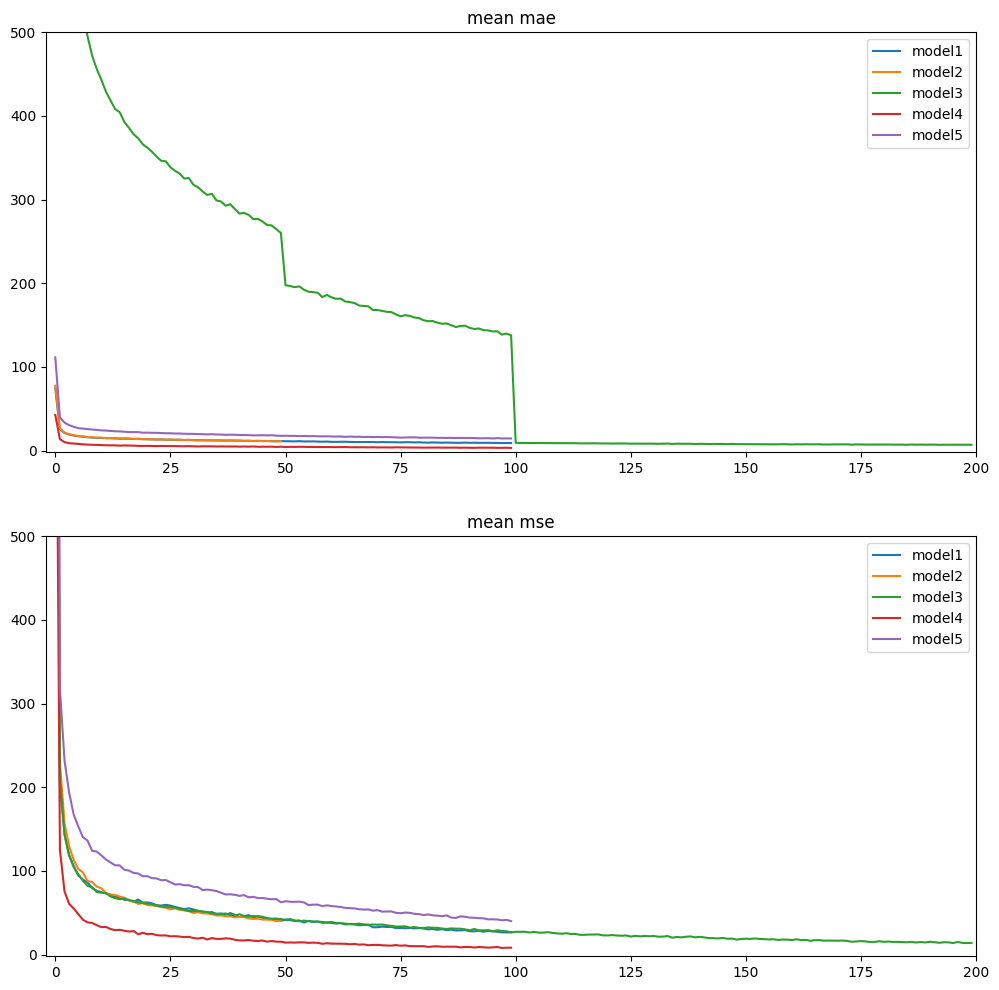

In [57]:
plot.clf()

plot.rcParams["figure.figsize"] = (12, 12)
figure, plot_arr = plot.subplots(2)
plot_arr[0].set_title('mean mae')
plot_arr[1].set_title('mean mse')

plot_arr[0].set_xlim([-2, 200])
plot_arr[0].set_ylim([-2, 500])

plot_arr[1].set_xlim([-2, 200])
plot_arr[1].set_ylim([-2, 500])

for x in all_mean_mae:
    plot_arr[0].plot(all_mean_mae[x], label='model' + str(x))
for x in all_mean_mse:
    plot_arr[1].plot(all_mean_mse[x], label='model' + str(x))


plot_arr[0].legend()
plot_arr[1].legend()

plot.show()